# When Will You Die In PLAYERUNKNOWN'S BATTLEGROUNDS?

## What is PLAYERUNKNOWN'S BATTLEGROUNDS?

PLAYERUNKNOWN'S BATTLEGROUNDS, aka PUBG, is a Battle Royale online game with an enormous player community. A battle royale game has typically 100 players in an arena with weapons and items scattered throughout the arena, where players drop into the map and try to gether loot in order to outlive everybody else.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import matplotlib as mpl
import seaborn as sns

In [3]:
d = pd.read_csv('agg_match_stats_0.csv')
e = pd.read_csv('agg_match_stats_1.csv')
a = pd.read_csv('agg_match_stats_2.csv')
t = pd.read_csv('agg_match_stats_3.csv')
h = pd.read_csv('agg_match_stats_4.csv')
x = pd.concat([d,e,a,t,h])
#d=d[d.party_size==1]
f = x[['game_size','match_mode','party_size','player_name','player_survive_time','team_placement','match_id','player_kills','player_dmg'
      ,'player_dist_ride','player_dist_walk','player_dbno']]
f['match_id'].astype(str)
f = f[f.party_size == 1]
f = f[f.player_survive_time <= 2000]
f.reset_index()
print(x.info())
print(f)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67369231 entries, 0 to 11993484
Data columns (total 15 columns):
date                   object
game_size              int64
match_id               object
match_mode             object
party_size             int64
player_assists         int64
player_dbno            int64
player_dist_ride       float64
player_dist_walk       float64
player_dmg             int64
player_kills           int64
player_name            object
player_survive_time    float64
team_id                int64
team_placement         int64
dtypes: float64(3), int64(8), object(4)
memory usage: 8.0+ GB
None
          game_size match_mode  party_size      player_name  \
494              91        tpp           1            Satch   
495              91        tpp           1   osamabinlaggon   
496              91        tpp           1       dengboyu76   
497              91        tpp           1       GOGingmimi   
498              91        tpp           1   AtomicBrunett

## What is the average amount of time that a player in a match will survive?

In [26]:
g = f.groupby('team_placement').player_survive_time.mean()
print(g)
i = f.groupby('match_id').player_survive_time.mean()
i = i[i <= 900]
print(i.head())
k = f.groupby('team_placement').count()

team_placement
1      1873.380034
2      1873.616051
3      1824.144466
4      1771.736636
5      1726.883338
6      1687.472575
7      1651.834665
8      1618.792180
9      1587.629970
10     1557.806085
11     1529.058968
12     1501.388448
13     1474.521495
14     1447.740803
15     1420.775116
16     1393.265046
17     1365.112949
18     1336.608056
19     1307.728003
20     1278.637713
21     1249.605479
22     1220.109384
23     1190.887350
24     1162.029637
25     1133.223595
26     1104.696852
27     1076.494001
28     1048.914846
29     1021.821273
30      995.369153
          ...     
71      232.297500
72      224.214715
73      216.799286
74      209.370795
75      202.075120
76      196.589349
77      189.959889
78      183.447579
79      178.508893
80      172.894102
81      168.236689
82      164.173696
83      161.109409
84      156.885502
85      152.869309
86      150.659238
87      149.085319
88      147.300016
89      147.130713
90      146.301677
91      148.8499

### Average survival time for each team placement

Histogram shows the probability of survival time in a game

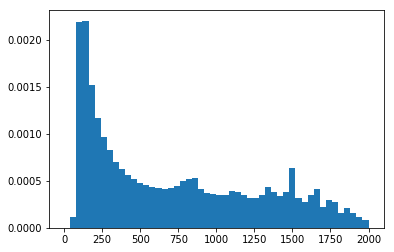

In [5]:
plt.hist(f.player_survive_time,bins=50,normed=True)
plt.show()

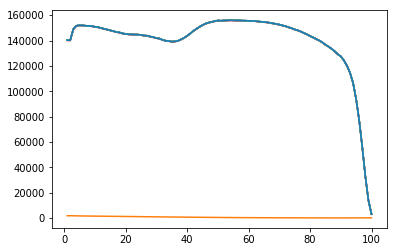

In [6]:
plt.plot(k)
plt.plot(g)

The average time a player is alive is higher as his team placement gets closer to one, which makes sense considering that whoever wins has outlived all other players in their match which gives him team placement of one. However, looking at the count and mean graph shows some irregularity towards the right hand side of the graph. The number of teams that place close to 100 are significantly less than teams that place higher. And also the average survival time of teams close to 100 are higher than what would be expected considering the trend of the rest of the means. This irregularity in the count can be understood if party size column is observed. Since we are looking at games that are not exclusively solo players, party size equal to one, this means that the number of teams in a match can be much less than 100 since only 100 players can be in any given match and party size in a match can differ.

In [22]:
mu = np.mean(i)
sigma = np.std(i)
fit = norm.pdf(i,np.mean(i),np.std(i))
print(mu,sigma)

722.3408393078654 66.25287484540112


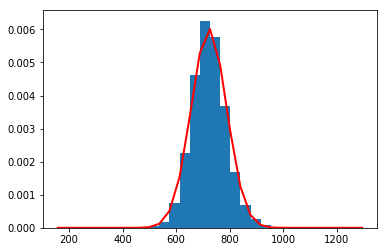

In [23]:
count, bins, ignored = plt.hist(i,bins=30,normed=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.show()

In [9]:
f['target_perc'] = f.team_placement / f.game_size
 

In [10]:
def dec(perc):
#     perc = f.team_placement / f.game_size
    if perc <= 0.1 and perc >= 0:
        return 1
    elif perc <= 0.2 and perc > 0.1:
        return 2
    elif perc <= 0.3 and perc > 0.2:
        return 3
    elif perc <= 0.4 and perc > 0.3:
        return 4
    elif perc <= 0.5 and perc > 0.4:
        return 5
    elif perc <= 0.6 and perc > 0.5:
        return 6
    elif perc <= 0.7 and perc > 0.6:
        return 7
    elif perc <= 0.8 and perc > 0.7:
        return 8
    elif perc <= 0.9 and perc > 0.8:
        return 9
    else:
        return 10

f['target_10_bins'] = f.target_perc.apply(dec)

In [11]:
f.target_10_bins.unique()

array([ 9, 10,  4,  6,  8,  7,  3,  1,  5,  2], dtype=int64)

In [12]:
f.target_perc

494         0.868132
495         0.956044
496         0.384615
497         0.505495
498         0.516484
499         0.989011
500         0.318681
501         0.527473
502         0.736264
503         0.692308
504         0.296703
505         0.835165
506         0.879121
507         0.582418
508         0.934066
509         0.230769
510         0.681319
511         0.637363
512         0.791209
513         0.307692
514         0.010989
515         0.857143
516         0.670330
517         0.219780
518         0.483516
519         0.285714
520         0.461538
521         0.329670
522         0.494505
523         0.802198
              ...   
11993185    0.095745
11993186    0.287234
11993187    0.148936
11993188    0.202128
11993189    0.776596
11993190    0.117021
11993191    0.882979
11993192    0.989362
11993193    0.819149
11993194    0.925532
11993195    0.010638
11993196    0.361702
11993197    0.446809
11993198    0.808511
11993199    1.000000
11993200    0.382979
11993201    0

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

data = f[['player_survive_time']]
data1 = f.target_10_bins

X_train,X_test,y_train,y_test = train_test_split(data,data1,test_size=0.3,random_state=42)
regr = LinearRegression()
regr.fit(X_train,y_train)

# f[['player_survive_time','team_placement','target_perc']]
# print(data.shape)
# print(data1.shape)
y_pred = regr.predict(X_test)
print('Coefficients: \n', regr.coef_)
print(regr)
# ,'player_kills','player_dmg'

Coefficients: 
 [-0.00490075]
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


plt.figure()
_=plt.scatter(X_test,y_test,marker='.',color='red',alpha=0.5,markersize=0.2)
mpl.rcParams['agg.path.chunksize'] = 1000000
plt.xticks([200,400,600,800,1000,1200,1400,1600,1800,2000])
plt.xlim(0,2000)
plt.yticks([1,2,3,4,5,6,7,8,9,10])
plt.figure()
plt.plot(X_test,y_pred)


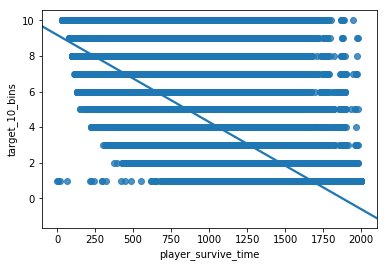

In [28]:
_=sns.regplot(f.player_survive_time,f.target_10_bins,fit_reg=True)
# plt.xticks([20,40,60,80,100])
# plt.yticks([1,2,3,4,5,6,7,8,9,10])

In [19]:
from statsmodels.formula.api import ols
m = ols('target_10_bins~player_survive_time',f).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         target_10_bins   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                 9.402e+07
Date:                Thu, 14 Jun 2018   Prob (F-statistic):               0.00
Time:                        21:11:58   Log-Likelihood:            -2.0509e+07
No. Observations:            14011203   AIC:                         4.102e+07
Df Residuals:                14011201   BIC:                         4.102e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               9.1928      0.000      2e+04      0.000       9.192       9.194
player_survive_time    -0.0049   5.05e-07  -9696.135      0.000      -0.005      -0.005
==============================================================================
Omnibus:                  4245829.271   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         24681320.306
Skew:                           1.337   Prob(JB):                         0.00
Kurtosis:                       8.927   Cond. No.                     1.49e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

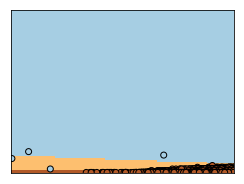

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

# import some data to play with
X = f[['player_survive_time','player_kills']]  # we only take the first two features.
Y = f.target_10_bins

h = 1.0  # step size in the mesh

logreg = linear_model.LogisticRegression(C=100)

# we create an instance of Neighbours Classifier and fit the data.
logreg.fit(X, Y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X.player_kills.min() - .5, X.player_kills.max() + .5
y_min, y_max = X.player_kills.min() - .5, X.player_kills.max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
# plt.xlabel('Sepal length')
# plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

In [16]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

Xlr,Xtestlr,ylr,ytestlr = train_test_split(f[['player_dmg','player_survive_time','player_kills']].values,
                                           (f.target_10_bins ==1).values,test_size=0.3,random_state=4)

logreg = LogisticRegression()
logreg.fit(Xlr,ylr)
print(accuracy_score(logreg.predict(Xtestlr), ytestlr))

0.9773564535618045


In [19]:
clf = LogisticRegression()
score = cv_score(clf, Xlr, ylr)
print(score)

0.9773756551258792


In [20]:
Cs = [0.001, 0.1, 1, 10, 100]
clf = LogisticRegression()
# your turn
from sklearn.linear_model import LogisticRegression
max_score = 0
for C in Cs:
    clf = LogisticRegression(C=C)
    score = cv_score(clf,Xlr,ylr)
    print(score, C)
    if score > max_score:
        max_score = score
        best_C = C
print("Max Score:",max_score, "Best C:", best_C)

0.9768719765341572 0.001
0.977375757085128 0.1
0.9773756551258792 1
0.9773759610036781 10
0.9773763688406216 100
Max Score: 0.9773763688406216 Best C: 100


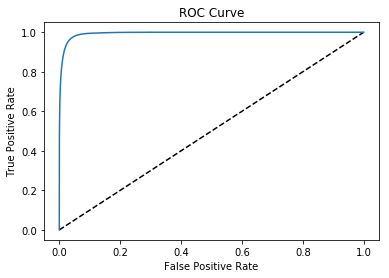

In [22]:
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(Xtestlr)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(ytestlr, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [23]:
Xtestlr

array([[2.000000e+01, 1.600017e+03, 1.000000e+00],
       [5.700000e+01, 1.187935e+03, 0.000000e+00],
       [0.000000e+00, 2.771430e+02, 0.000000e+00],
       ...,
       [2.610000e+02, 1.622733e+03, 2.000000e+00],
       [3.000000e+02, 3.091500e+02, 2.000000e+00],
       [1.150000e+02, 1.014256e+03, 1.000000e+00]])

In [24]:
import sklearn

def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = sklearn.model_selection.GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: {:0.2f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

In [25]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.001,0.01, 0.1, 1, 10, 100]}, 
                                                           f, ['team_placement','player_survive_time','player_kills'],
                                                           'target_10_bins',1)

C:\Users\michael\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


BEST PARAMS {'C': 0.001}
Accuracy on training data: 0.99
Accuracy on test data:     0.99
